In [35]:
# transformer plus cellular automata: precomputed
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F

batch_size = 2
block_size = 32
max_iter = 1000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embed = 32
n_head = 2
n_layer = 2
dropout = 0.01

torch.manual_seed(100)

def cellular_automata(grid_size, step_count, rule):
    """Generates a grid based on cellular automata rules."""
    grid = np.random.randint(5, size=(grid_size, grid_size))
    for _ in range(step_count):
        new_grid = np.zeros_like(grid)
        for i in range(grid_size):
            for j in range(grid_size):
                # Define neighborhood
                neighborhood = grid[(i-1):(i+2), (j-1):(j+2)].flatten()
                # Apply rule to determine next state
                new_grid[i, j] = rule(neighborhood)
        grid = new_grid
    return grid

def example_rule(neighborhood):
    result = np.sum(neighborhood)
    # prod = np.prod(neighborhood) % 4
    result = (result) % 4
    return result

# Encodes cellular automata grid to sequence of tokens
def grid_to_sequence(grid):
    flat_grid = grid.flatten()
    sequence = ''.join(tokens[i % len(tokens)] for i in flat_grid)
    return sequence

# create dictionaries and then define unique characters for encoding and decoding
tokens = ['A', 'T', 'C', 'G']

# Example usage with cellular automata
grid_size = 1000  # Grid size for the cellular automata
step_count = 2  # Number of steps to evolve the cellular automata
automata_grid = cellular_automata(grid_size, step_count, example_rule)
text = grid_to_sequence(automata_grid)

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[c] for c in s]
dec = lambda l: ''.join([itos[i] for i in l])

#  train and test splits
data = torch.tensor(enc(text), dtype = torch.long)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(len(train_data))

# train_data test visualisation
# offset = 1
# x = train_data[offset+1:block_size+offset]
# y = train_data[1+offset:block_size+1+offset]
# for t in range(block_size):
#     context = x[:t+1]
#     target = y[t]
#     print(f"when input is {context} then target is: {target}")

# load data %%
def get_batch(split):
    data = train_data if split == 'train' else val_data
    if len(data) <= block_size:
        raise ValueError(f"Data length {len(data)} is too small for block size {block_size}")
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k]= loss.item()
        out[split] = losses.mean()
    model.train()
    return(out)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.ReLU(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # add x for residual connections
        x = x + self.ffwd(self.ln1(x))
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            loss = F.cross_entropy(logits, targets)
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iter):
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f},val loss {losses['val']:4f}")
    xb,yb = get_batch('train')
    logits, loss = m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype = torch.long, device = device)
print(dec(m.generate(context, max_new_tokens=500)[0].tolist()))

900000
step 0: train loss 1.3915,val loss 1.388822
step 50: train loss 1.3878,val loss 1.388502
step 100: train loss 1.3879,val loss 1.387109
step 150: train loss 1.3920,val loss 1.389737
step 200: train loss 1.3884,val loss 1.388030
step 250: train loss 1.3878,val loss 1.387489
step 300: train loss 1.3879,val loss 1.387523
step 350: train loss 1.3877,val loss 1.386928
step 400: train loss 1.3873,val loss 1.386714
step 450: train loss 1.3866,val loss 1.387355
step 500: train loss 1.3874,val loss 1.387710
step 550: train loss 1.3862,val loss 1.387200
step 600: train loss 1.3873,val loss 1.387906
step 650: train loss 1.3865,val loss 1.387132
step 700: train loss 1.3863,val loss 1.386712
step 750: train loss 1.3866,val loss 1.386715
step 800: train loss 1.3866,val loss 1.386782
step 850: train loss 1.3864,val loss 1.386773
step 900: train loss 1.3868,val loss 1.386871
step 950: train loss 1.3868,val loss 1.386789
AAGATCCCTACCGTCCCGGCCAACGCCATACGGAGCCTATAGGTATAAAGGAACCGCTGATCGTACTACACTGCGA


Generated from CA is: AAAAAGCCAGTAATAT


Generated from T is: TAGAGGCAATGCGATC



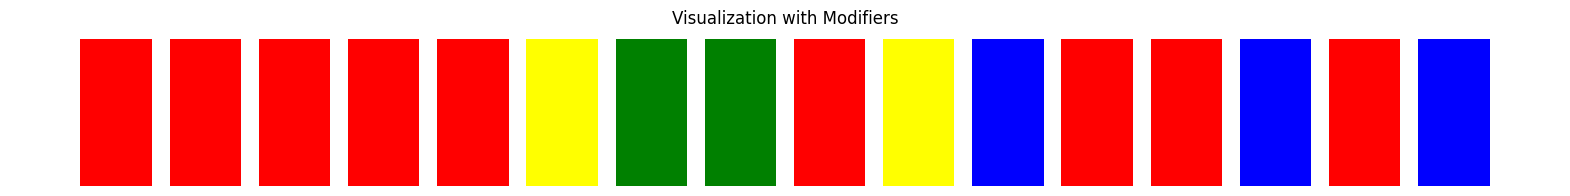

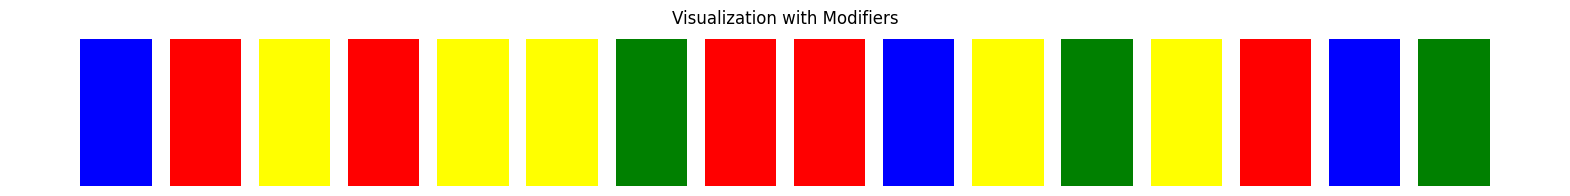

In [46]:
# Generate a sequence
input_sequence = "ATCG"
context = torch.tensor(enc(input_sequence), dtype=torch.long, device=device).unsqueeze(0)
output = model.generate(context, max_new_tokens=4*len(input_sequence))
generated_text_t = dec(output[0].tolist())
generated_text_ca = grid_to_sequence(cellular_automata(len(input_sequence), step_count, example_rule))

def visualize_grid_with_modifiers(grid):
    """Visualise the grid."""
    base_colors = {'A': 'red', 'T': 'blue', 'C': 'green', 'G': 'yellow'}
    colors = []
    for row in grid:
        row_colors = [base_colors[base] for base in row]
        colors.extend(row_colors)

    plt.figure(figsize=(20, 2))
    plt.bar(range(len(colors)), np.ones(len(colors)), color=colors)
    plt.axis('off')
    plt.title('Visualization with Modifiers')
    plt.show()

print(f"\nGenerated from CA is: {generated_text_ca}\n")
print(f"\nGenerated from T is: {generated_text_t[4:]}\n")
visualize_grid_with_modifiers(generated_text_ca)
visualize_grid_with_modifiers(generated_text_t[4:])